# Imports + Base Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np # useful for calculations
import h5py #required to read hdf5 files
import matplotlib as mpl
from tqdm import tqdm
from scipy import spatial
from scipy.optimize import curve_fit
import pdb
import pickle
from photutils.profiles import RadialProfile
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import radial_profile_3d

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    'figure.figsize': (9, 6),
    'agg.path.chunksize': 2000,
    'xtick.direction': 'in',
    'xtick.major.size': 6,
    'xtick.major.width': 1,
    'ytick.direction': 'in',
    'ytick.major.size': 6,
    'ytick.major.width': 1,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.top': True,
    'ytick.right': True,
})

plt.style.use('dark_background')

FloatType = np.float64  # double precision: np.float64, for single use np.float32

def read_gadget_snapshot(file_name):
	data = h5py.File(file_name, 'r')  # load full hdf5 file
	time = FloatType(data['Header'].attrs['Time']) # the scale factor at which snapshot was written
	BoxSize = FloatType(data['Header'].attrs['BoxSize']) # box size in code units (Mpc)
	Pos = np.array(data['PartType1']['Coordinates'], dtype=FloatType) #3d Positions of all particles, e.g. x coord: Pos[:,0]
	mass = FloatType(data['Header'].attrs['MassTable'][1]) # mass of one DM particle
	n_particles = Pos.size // 3
	return time, Pos, mass, n_particles, BoxSize

file_name = "snapshot_002.hdf5"
time, Pos, mass, n_particles, BoxSize = read_gadget_snapshot(file_name)

In [3]:
with open('halos.pkl', 'rb') as file:
    halos = pickle.load(file)

In [4]:
x=Pos[:, 0]
y=Pos[:, 1]
z=Pos[:, 2]

plt.rc('font', family='sans')
plt.rcParams.update({
    'agg.path.chunksize': 2000,
    'xtick.direction': 'out',
    'xtick.major.size': 6,
    'xtick.major.width': 1,
    'xtick.minor.size': 3,
    'xtick.minor.width': 0.8,
    'xtick.minor.visible': False,
    'ytick.direction': 'out',
    'ytick.major.size': 6,
    'ytick.major.width': 1,
    'ytick.minor.size': 3,
    'ytick.minor.width': 0.8,
    'ytick.minor.visible': False,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.top': False,
    'ytick.right': False,
})

plt.style.use('dark_background')

In [5]:
sizes = np.array([len(h) for h in halos])
halo3 = halos[2]
n_halo3 = len(halo3)
Pos3 = Pos[halo3]
x3=Pos3[:, 0]
y3=Pos3[:, 1]
z3=Pos3[:, 2]

In [6]:
center = [x3[4422], y3[4422], z3[4422]]

In [7]:
def nfw(r, rho_0, r_s):
    return rho_0 / ((r / r_s) * (1 + r / r_s)**2)


Best-fit NFW parameters:
rho_0 = 4.408e+06
r_s   = 7.707e-02


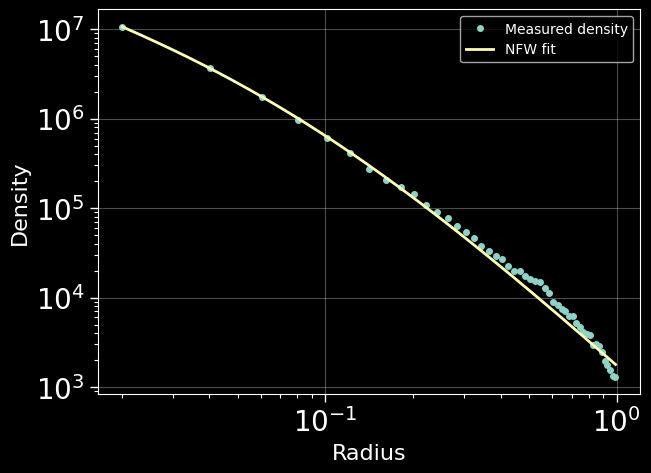

In [8]:
r = np.linalg.norm(Pos3 - center, axis=1)
rbins = np.linspace(0.01, 1, 50)
counts, _ = np.histogram(r, bins=rbins)

r_inner = rbins[:-1]
r_outer = rbins[1:]
shell_vol = (4/3) * np.pi * (r_outer**3 - r_inner**3)

density = counts / shell_vol
r_mid = 0.5 * (r_inner + r_outer)

mask = (density > 0)
r_fit = r_mid[mask]
rho_fit = density[mask]

popt, pcov = curve_fit(
    lambda r, rho_s, r_s: nfw(r, rho_s, r_s),
    r_fit,
    rho_fit,
    # p0=[np.max(rho_fit), np.median(r_fit)],  # initial guesses
    maxfev=20000
)

rho_s_fit, r_s_fit = popt
print("Best-fit NFW parameters:")
print(f"rho_0 = {rho_s_fit:.3e}")
print(f"r_s   = {r_s_fit:.3e}")

# Plot
r_smooth = np.logspace(np.log10(r_fit.min()), np.log10(r_fit.max()), 200)
rho_smooth = nfw(r_smooth, rho_s_fit, r_s_fit)

plt.figure(figsize=(7,5))
plt.loglog(r_fit, rho_fit, 'o', label='Measured density', markersize=4)
plt.loglog(r_smooth, rho_smooth, '-', linewidth=2, label='NFW fit')
plt.xlabel("Radius")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()